#Model Prediksi dan Klusterisasi Penyakit Jantung menggunakan Decision Tree dan K-means

Sumber data: https://archive.ics.uci.edu/dataset/45/heart+disease

Dataset memiliki 13 fitur yang akan digunakan untuk pembelajaran algoritma decision tree. Dataset memiliki missing value sehingga harus dilakukan beberapa tahapan preprocessing.

##Import library yang akan digunakan

 Untuk melakukan modeling, kita akan menggunakan beberapa library:

 - pandas
 -numpy
 - scikit learn

In [23]:
import pandas as pd
import numpy as  np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, classification_report

##Import dataset


In [2]:
from google.colab import files
uploaded = files.upload()

Saving processed.cleveland.data to processed.cleveland.data


In [3]:
df = pd.read_csv('processed.cleveland.data', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


Pertama-tama, kita akan mengubah nama kolom pada dataframe menjadi nama kolom yang tersedia di dataset information resmi:

- age
- sex
- cp : chest pain
- restbp : resting blood pressure (in mm Hg)
- chol : cholesterol in mg/dl
- fbs : fasting blood sugar
- restcg : resting electrocardiographic results
- thalach : maximum heart rate achieved
- exang : exercise included angina
- oldpeak : ST depression incuded by exercise relative to rest
- slope : the slope of the peak exercise ST segment
- ca : number of major vessels
- thal : this is short of thadium heart scan
- hd : diagnosis of heart disease, the **predicted attribute**

In [4]:
df.columns = [
    'age',
    'sex',
    'cp',
    'restbp',
    'chol',
    'fbs',
    'restcg',
    'thalach',
    'exang',
    'oldpeak',
    'slope',
    'ca',
    'thal',
    'hd'
]

df.head()

,age,sex,cp,restbp,chol,fbs,restcg,thalach,exang,oldpeak,slope,ca,thal,hd
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


Now we are ready to deal and identify missing data !

## Missing Data: Mengidentifikasi missing value

**Missing value** adalah space kosong yang terdapat pada dataset yang biasanya dianotasikan dengan N/A yang menandakan bahwa kita tidak memiliki data tersebut

Terdapat dua cara untuk menangani missing value :

1. Hapus baris data yang memiliki missing value.
2. Melakukan **impute** missing value dengan pengukuran seperti mean atau median.

Mari kita lihat tipe data masing-masing kolom

In [5]:
df.dtypes

,0
age,float64
sex,float64
cp,float64
restbp,float64
chol,float64
fbs,float64
restcg,float64
thalach,float64
exang,float64
oldpeak,float64


Kita dapat melihat bahwa **ca** dan **thal** memiliki tipe data object sedangkan berdasarkan informasi resmi dataset, kolom tersebut seharusnya bertipe data numerik.

In [6]:
df['ca'].unique()

array(['0.0', '3.0', '2.0', '1.0', '?'], dtype=object)

Jika kita lihat, kolom ca memiliki missing value yang ditandai dengan "?"

In [ ]:
df['thal'].unique()

array(['6.0', '3.0', '7.0', '?'], dtype=object)

Kolom thal juga memiliki missing value. Selanjutnya kita akan menghitung jumlah missing value yang terdapat pada kedua kolom.

In [7]:
len(df)

303

In [8]:
len(df.loc[(df['ca'] == '?') | (df['thal'] == '?')])

6

Since there's only six rows with missing values, we're just gonna remove them because we still have a relatively large data.

Karena kita hanya memiliki 6 missing value, maka kita akan menghapusnya karena kita masih memiliki jumlah data yang banyak

In [9]:
df_no_missing = df.loc[(df['ca'] != '?') & (df['thal'] != '?')]
len(df_no_missing)

297

Sekarang kita memiliki 297 data yang akan kita gunakan untuk training model

##Format data: Split data menjadi feature dan target

Before we move our way to build the classification tree, we're gonna have to split the predictors variables (independent denote as X) and the target variable (Target denote as y).

Sebelum kita mulai melakukan fit model, kita harus memisahkan variable predictor (dianotasikan dengan X) dan juga target variable (dianotasikan dengan y)

In [10]:
X = df_no_missing.drop('hd', axis=1).copy()
X.head()

,age,sex,cp,restbp,chol,fbs,restcg,thalach,exang,oldpeak,slope,ca,thal
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0


In [11]:
y = df_no_missing['hd'].copy()
y.head()

,hd
0,0
1,2
2,1
3,0
4,0


the target column has more than 2 distinct values and we're gonna make the values only contain 0s and 1s.

This means that 0 value suggests that patienet had no heart disease
and that 1 value suggests that the patient had heart disease.

Jika kita membaca informasi resmi dataset, target value terpisah menjadi beberapa tingkat penyakit jantung. Untuk memudahkan training, kita hanya akan memisahkan pasien yang memiliki penyakit jantung (tingkat apapun) dan yang tidak memiliki penyakit jantung.

Maka kita akan merubah target value hanya menjadi 0 dan 1

In [12]:
y_hd = y > 0
y[y_hd] = 1
y.unique()

array([0, 1])

Selain itu, beberapa kolom di dataset juga bersifat categorical yang artinya kita harus melakukan one-hot encoding. Untuk melakkan one-hot encoding, kita akan menggunakan method dari pandas yaitu pd.get_dummies() karena cukup sederhana.

In [13]:
X_encoded = pd.get_dummies(X, columns=['cp', 'restcg', 'slope', 'thal'])
X_encoded.head()

,age,sex,restbp,chol,fbs,thalach,exang,oldpeak,ca,cp_1.0,...,cp_4.0,restcg_0.0,restcg_1.0,restcg_2.0,slope_1.0,slope_2.0,slope_3.0,thal_3.0,thal_6.0,thal_7.0
0,63.0,1.0,145.0,233.0,1.0,150.0,0.0,2.3,0.0,True,...,False,False,False,True,False,False,True,False,True,False
1,67.0,1.0,160.0,286.0,0.0,108.0,1.0,1.5,3.0,False,...,True,False,False,True,False,True,False,True,False,False
2,67.0,1.0,120.0,229.0,0.0,129.0,1.0,2.6,2.0,False,...,True,False,False,True,False,True,False,False,False,True
3,37.0,1.0,130.0,250.0,0.0,187.0,0.0,3.5,0.0,False,...,False,True,False,False,False,False,True,True,False,False
4,41.0,0.0,130.0,204.0,0.0,172.0,0.0,1.4,0.0,False,...,False,False,False,True,True,False,False,True,False,False


##Membangun model tree

Sebelum kita membangun model tree, kita akan memisahkan data menjadi train dan test set terlebih dahulu

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=42)

# Inisialisasi model
clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha=0.01422)
clf_dt.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.01422, random_state=0)

##Visualisasi Model Tree

Untuk visualisai model tree, kita akan menggunakan bantuan method plot_tree yang sudah tersedia

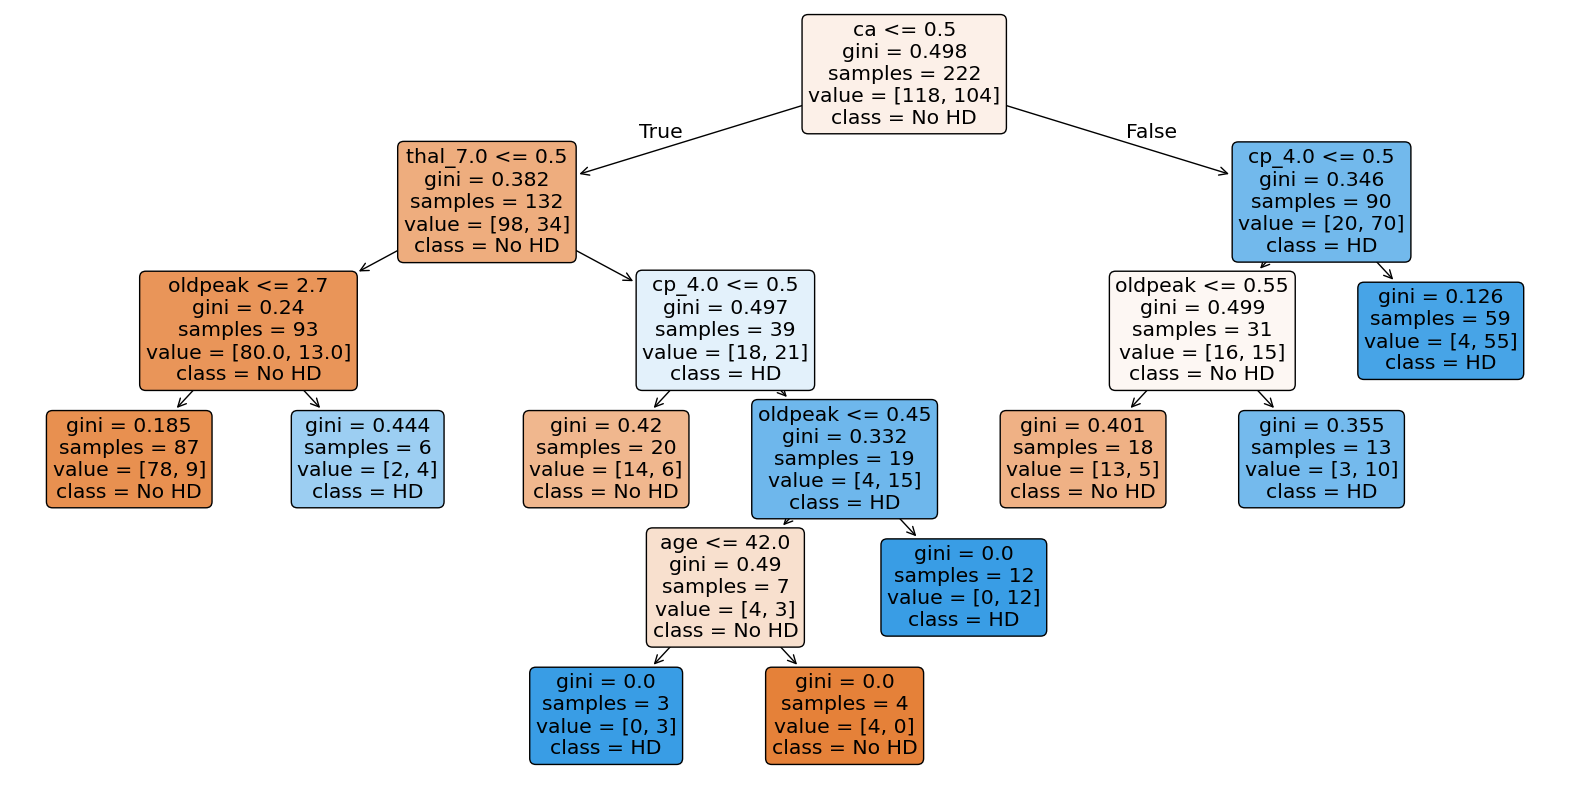

In [31]:
# Visualisasi model Tree
plt.figure(figsize=(20, 10))
plot_tree(
    clf_dt,
    feature_names=X_train.columns,
    class_names=['No HD', 'HD'],
    filled=True,
    rounded=True
)

# Simpan gambar sebagai PNG
plt.savefig("decision_tree.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

Evaluate using the confusion matrix

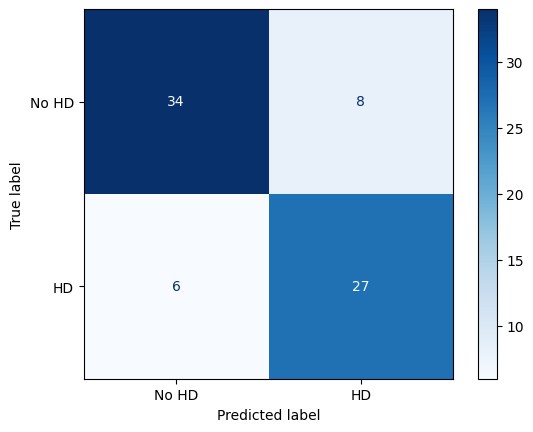

In [33]:
disp = ConfusionMatrixDisplay.from_estimator(
    clf_dt,
    X_test,
    y_test,
    display_labels=['No HD', 'HD'],
    cmap=plt.cm.Blues
)

# Simpan gambar sebagai PNG
plt.savefig("confusion_matrix.png", format="png", bbox_inches="tight", dpi=300)

plt.show()

Jika kita melihat hasil confusion matrix, model dapat melakukan prediksi dengan cukup baik dan sedikit kesalahan

## Evaluasi model menggunakan metric

Selanjutnya kita akan mengevaluasi model lebih lanjut menggunakan beberapa metric seperti accuracy, precision, recall, dan f1-score

In [24]:
y_pred = clf_dt.predict(X_test)

# Menghitung akurasi
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

Accuracy: 0.81
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.81      0.83        42
           1       0.77      0.82      0.79        33

    accuracy                           0.81        75
   macro avg       0.81      0.81      0.81        75
weighted avg       0.82      0.81      0.81        75



Kita mendapatkan hasil yang cukup baik dengan akurasi di atas 80%

##Clustering menggunakan K-means

Karena k-means cukup sensitif terhadap skala data, maka kita akan melakuakn sebuah scaling terlebih dahulu

In [25]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Dikarenakan kita sudah tahu bahwa dataset terbagi menjadi dia kategori, kita akan set jumlah centroid menjadi 2. Selain itu, kita juga bisa melakukan beberapa teknik seperti elbow-method

In [29]:
actual_clusters = 2
kmeans = KMeans(n_clusters=actual_clusters, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

##Visualisasi model clustering

Selanjutnya kita akan melakukan visualisasi hasil clustering menggunakan PCA

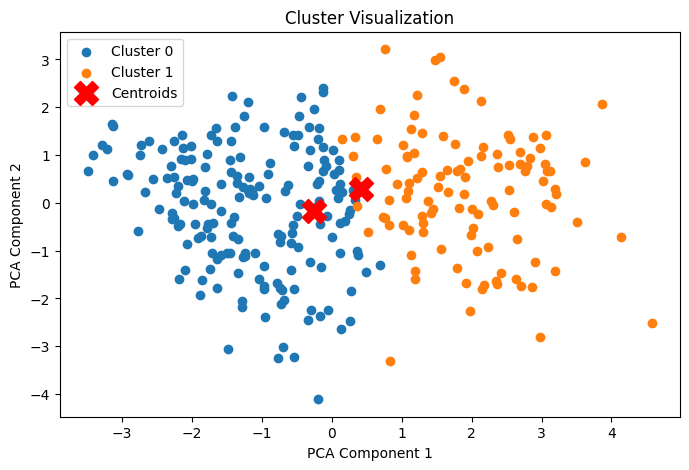

In [34]:
from sklearn.decomposition import PCA

# Reduksi dimensi
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot cluster
plt.figure(figsize=(8, 5))
for cluster in range(actual_clusters):
    plt.scatter(X_pca[clusters == cluster, 0],
                X_pca[clusters == cluster, 1],
                label=f"Cluster {cluster}")

plt.scatter(kmeans.cluster_centers_[:, 0],
            kmeans.cluster_centers_[:, 1],
            s=300, c='red', marker='X', label='Centroids')
plt.title("Cluster Visualization")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()

plt.savefig("K-means clustering.png", format="png", bbox_inches="tight", dpi=300)

plt.show()

Berdasarkan hasil clustering, kita dapat melihat adanya cluster yang terpisah terutama pada axis PCA 1